In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import copy
from keras.layers import LSTM
from keras import optimizers as opt

import mbspbs10pc.model as mbs_model
from mbspbs10pc import read_activations, utils
reload(mbs_model)
reload(read_activations)
reload(utils);
%matplotlib inline

# Load data

In [3]:
labelsfile = '../../tmp/1_METONLY_vs_METX/matched_CEM_table.csv'
datafile = '../../tmp/item_days_raw_data_.pkl'
dataset = utils.load_data_labels(datafile, labelsfile)
padded_mbs_seq, padded_timestamp_seq, tokenizer = utils.tokenize(dataset)
maxlen = padded_mbs_seq.shape[1]

# Split in training, validation, test sets
tr_set, v_set, ts_set = utils.train_validation_test_split(
    [padded_mbs_seq, padded_timestamp_seq], dataset['Class'],
    test_size=0.4, validation_size=0.1,
    verbose=False, random_state0=42, random_state1=420)

In [6]:
dataset.head()

,Seq,Class,mbs_seq,times_seq
PIN,,,,
568483,10990 0 23 16 725 0 10990 0 10990 0 10990 0 10...,1,10990 23 725 10990 10990 10990 10993 23 85311 ...,0 16 0 0 0 0 0 15 0 0 13 0 0 0 22 0 0 0 0 0 0 ...
923748,66653 0 65070 0 66515 5 10962 1 105 1 56807 42...,0,66653 65070 66515 10962 105 56807 10990 23 109...,0 0 5 1 1 42 0 26 35 0 0 0 9 0 0 0 5 0 0 0 21 ...
2035328,66536 0 74995 0 66512 0 66551 0 66608 0 66716 ...,0,66536 74995 66512 66551 66608 66716 66560 7392...,0 0 0 0 0 0 0 9 1 10 9 138 1 3 31 24 63 0 0 0 ...
2239386,10991 0 23 105 73928 0 66560 0 66515 0 66551 0...,1,10991 23 73928 66560 66515 66551 66536 2517 10...,0 105 0 0 0 0 4 2 27 1 1 7 0 18 132 0 0 0 1 0 ...
2244533,10990 0 23 74 23 0 10990 1 73928 0 66500 0 665...,1,10990 23 23 10990 73928 66500 66560 66551 23 1...,0 74 0 1 0 0 0 2 0 87 0 1 0 0 0 0 0 2 0 6 0 8 ...


In [7]:
# x = tr_set[0][0]
# t = tr_set[0][1].squeeze()

In [22]:
# Build an inverse word map
word_map = {tokenizer.word_index[k]: k for k in tokenizer.word_index.keys()}
word_map[0] = 0

In [78]:
item_map = pd.read_csv('../../mbspbs10pc/data/item_map.tsv', sep='\t', header=0, index_col=0,
                      usecols=['ITEM', 'Mapped_Item_Desc', 'CATEGORY_DESC'])
item_map.loc[0, :] = ['', '']
item_map.head()

,Mapped_Item_Desc,CATEGORY_DESC
ITEM,,
1,Professional attendance by a general practitio...,PROFESSIONAL ATTENDANCES
2,Professional attendance by a general practitio...,PROFESSIONAL ATTENDANCES
3,Professional attendance at consulting rooms (n...,PROFESSIONAL ATTENDANCES
4,Consultation at a place other than consulting ...,PROFESSIONAL ATTENDANCES
5,Professional attendance at consulting rooms of...,PROFESSIONAL ATTENDANCES


# Load model

In [12]:
model = mbs_model.build_model(mbs_input_shape=(maxlen,),
                              timestamp_input_shape=(maxlen, 1),
                              vocabulary_size=2774,
                              embedding_size=50,
                              recurrent_units=32,
                              dense_units=32,
                              bidirectional=True,
                              LSTMLayer=LSTM)

model.load_weights('../../tmp/auc_879/output_weights.h5')

# Visualize the attention weights

In [13]:
D = copy(ts_set)

alpha = read_activations.get_activations(model, D[0], print_shape_only=True, layer_name='tsg_attention')[0]
omega = read_activations.get_activations(model, D[0], print_shape_only=True, layer_name='contribution')[0]

----- activations -----
(4698, 250, 64)
----- activations -----
(4698, 250, 64)


In [14]:
W_fc = model.get_layer(name='fc').get_weights()[0]
W_out = model.get_layer(name='fc_output').get_weights()[0]
W = W_fc.dot(W_out)  # 50 x 1
We = model.get_layer(name='mbs_embedding').get_weights()[0]  # 2774 x 50
w = We[D[0][0]].dot(W).squeeze()  # 6341 x 445
print(w.shape)

(4698, 250)


In [15]:
# avg_alpha = np.mean(alpha, axis=-1).squeeze()
avg_omega = np.mean(omega, axis=-1).squeeze()
avg_omega.shape

(4698, 250)

In [16]:
c = w * avg_omega
print(c.shape)

(4698, 250)


In [17]:
neg = np.where(D[1] == 0)[0]
pos = np.where(D[1] == 1)[0]

Group class attention:

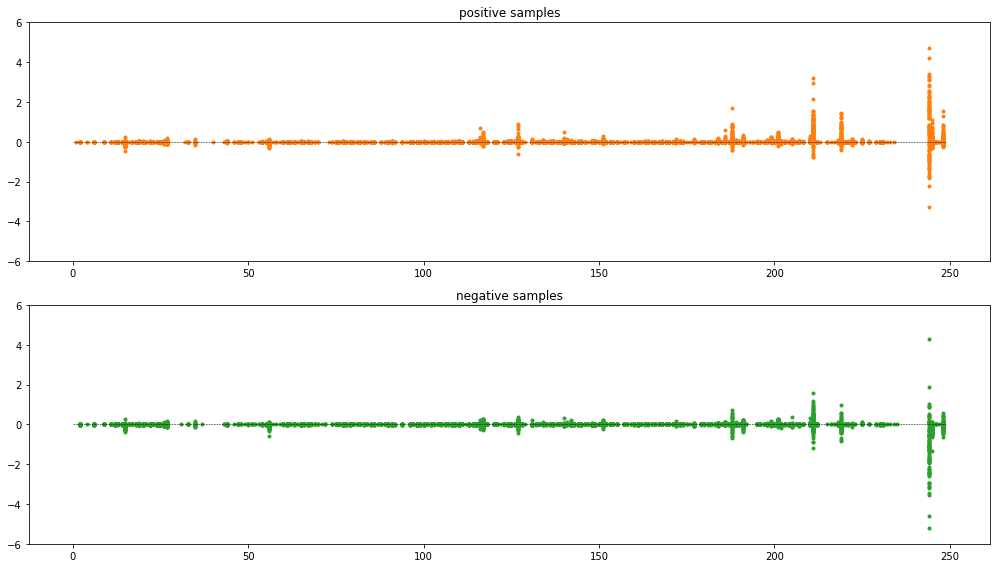

In [187]:
def zero_to_nan(row, p=75):
    out = np.array(row)
    _idx = np.where(np.abs(row) < np.percentile(np.abs(row), p))[0]
    out[_idx] = float('nan')
    return out


xaxis = np.arange(avg_omega.shape[1])

plt.figure(figsize=(14, 8))
plt.subplot(2,1,1)
for i in pos[:100]:
    plt.plot(xaxis, zero_to_nan(c[i, :].T), '.', color='C1')
plt.plot(xaxis, np.zeros_like(xaxis), '--', color='k', linewidth=0.5)
# plt.xlim([150, 250])
plt.ylim([-6, 6])
plt.title('positive samples')

plt.subplot(2,1,2)
for i in neg[:100]:
    plt.plot(xaxis, zero_to_nan(c[i, :].T), '.', color='C2')
plt.plot(xaxis, np.zeros_like(xaxis), '--', color='k', linewidth=0.5)
# plt.xlim([150, 250])
plt.ylim([-6, 6])
plt.title('negative samples')

plt.tight_layout();

Single attention:

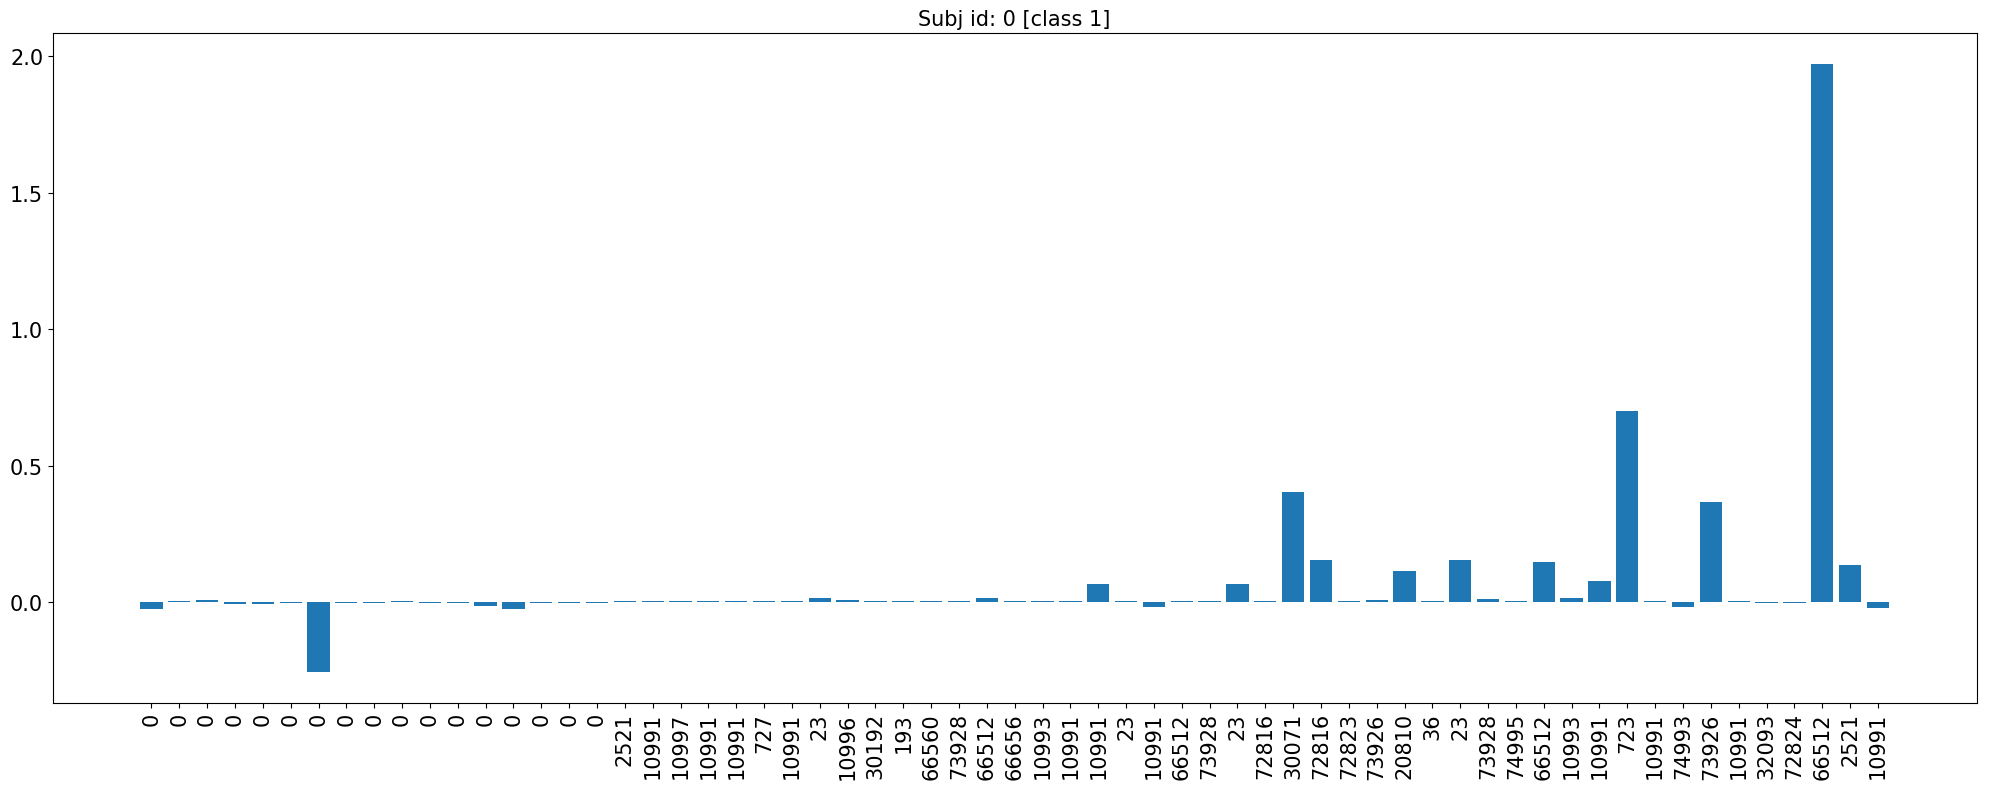

In [165]:
import seaborn as sns

def attention_viz(i):
    # Load the mbs sequence from the dataset
    tokenized_seq = D[0][0][i]
    mbs_seq = np.array([word_map[tk] for tk in tokenized_seq])
    
    # Retrieve the corresponding attention vector
    attention = c[i].squeeze()
    
    # Filter out small attentions
    _idx = np.where(np.abs(attention) >= np.percentile(np.abs(attention), 75))[0]
    axis = np.arange(len(_idx))
    
    plt.bar(axis, attention[_idx])
    plt.xticks(axis, mbs_seq[_idx], rotation='vertical', fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('Subj id: {} [class {}]'.format(i, D[1][i]), fontsize=15)
    plt.tight_layout();
    

plt.figure(dpi=100, figsize=(20, 8))
attention_viz(0)

## Which MBS items get more attention?

In [157]:
from tqdm import tqdm, trange

def get_MBS_attention():
    # Save absolute value of attention level for each MBS item
    attention_dict = {}
    for i in trange(D[0][0].shape[0]):
        # Load the mbs sequence from the dataset
        tokenized_seq = D[0][0][i]
        mbs_seq = np.array([word_map[tk] for tk in tokenized_seq])
        
        # Retrieve the corresponding attention vector
        attention = np.abs(c[i].squeeze())
        
        # Keep nonzero only
        nz = np.where(mbs_seq != '0')[0]
        mbs_seq, attention = mbs_seq[nz], attention[nz]
        
        # Keep only the TOP 5%
        top_idx = np.where(attention >= np.percentile(attention, 75))[0]
        mbs_seq, attention = mbs_seq[top_idx], attention[top_idx]
    
        # Update the dict
        for item, att in zip(mbs_seq, attention):
            if item in attention_dict:
                attention_dict[item].append(att)
            else:
                attention_dict[item] = [att]
    
    return attention_dict

attention = get_MBS_attention()

100%|██████████| 4698/4698 [00:02<00:00, 1836.69it/s]


In [158]:
avg_attention = {k: np.sum(attention[k]) for k in attention.keys()}
dfa = pd.DataFrame(data=avg_attention.values(), index=avg_attention.keys(), columns=['Attention_overall'])
dfa['Mapped_Item_Desc'] = [item_map.loc[i, 'Mapped_Item_Desc'] for i in map(int, dfa.index)]
dfa['CATEGORY_DESC'] = [item_map.loc[i, 'CATEGORY_DESC'] for i in map(int, dfa.index)]

In [159]:
dfa.nlargest(25, columns='Attention_overall')

,Attention_overall,Mapped_Item_Desc,CATEGORY_DESC
23,2147.151123,Professional attendance by a general practitio...,PROFESSIONAL ATTENDANCES
10990,1720.247681,A medical service to which an item in this tab...,MISCELLANEOUS SERVICES
10991,1391.549438,A medical service to which an item in this tab...,MISCELLANEOUS SERVICES
73928,681.794189,Initiation of a patient episode by collection ...,PATHOLOGY SERVICES
66512,604.222961,5 or more tests described in item 66500,PATHOLOGY SERVICES
74995,534.763794,A payment when the episode is bulk billed and ...,PATHOLOGY SERVICES
36,381.273132,Professional attendance by a general practitio...,PROFESSIONAL ATTENDANCES
66551,303.028381,Quantitation of glycated haemoglobin performed...,PATHOLOGY SERVICES
65070,274.627258,"Erythrocyte count, haematocrit, haemoglobin, c...",PATHOLOGY SERVICES
66560,260.001587,Microalbumin - quantitation in urine,PATHOLOGY SERVICES


# Embedding viz

In [188]:
X = read_activations.get_activations(model, D[0], print_shape_only=True, layer_name='pooling')[0]

----- activations -----
(4698, 50)


In [189]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

X_r = PCA(n_components=3).fit_transform(X)

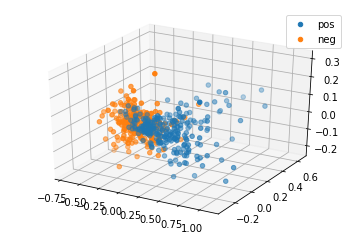

In [191]:
%matplotlib inline
MAX = 250

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_r[pos[:MAX], 0], X_r[pos[:MAX], 1], X_r[pos[:MAX], 2], c='C0', label='pos')
ax.scatter(X_r[neg[:MAX], 0], X_r[neg[:MAX], 1], X_r[pos[:MAX], 2], c='C1', label='neg')
plt.legend();